0.0
0.0
0.0


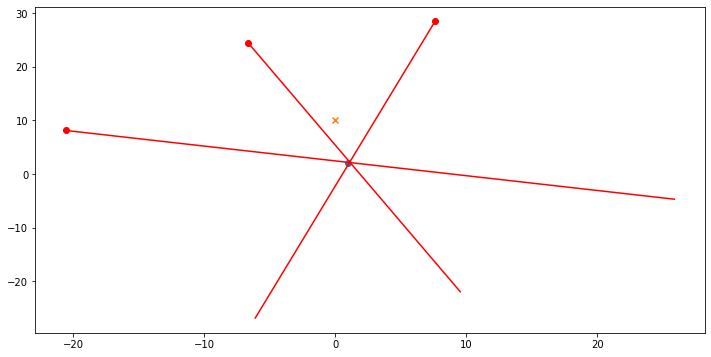

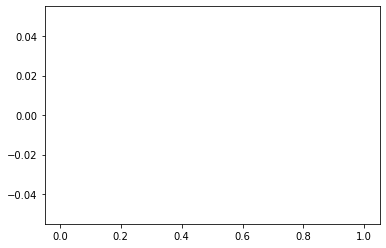

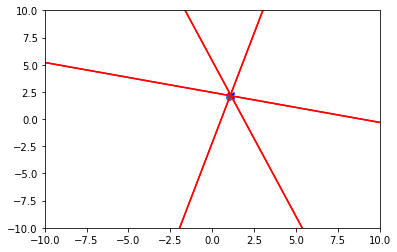

Intersections: 3
(1.0840781958974843, 2.154260858884026)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import math

class ray:
    
    #This is defined wrt (0,0)
    def __init__(self,o,a,l,sigma_angle=0.,sigma_x=0.,sigma_y=0.):
        
        #This is the original information
        self.origin = o
        self.angle  = a
        
        #This is the ray reference point at creation (equals the origin)
        self.refPoint = self.origin
        
        
        #y-y0 = m*(x-x0), with m = tan(angle)
        #k    = -m*x0 +y0
        #Ay = Bx + C
        self.tanA = math.tan(a)
        self.m = math.tan(a)
        self.k = -self.m*self.origin[0] + self.origin[1]        
        self.length = l
        self.sigma_angle = sigma_angle
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        
        self.d0 = self.getD0fromPoint(self.origin) #this should be always 0.0
        self.d0err = self.getInitialD0Error() #initial error coming from the uncertainty of the origin+angle
        print(self.d0err)
        #2x2 diagonal matrix
        self.covariance = np.array([[self.d0err*self.d0err,0.0],[0.0,self.sigma_angle*self.sigma_angle]])
        
        self.end = [self.origin[0] + math.cos(self.angle)*self.length, self.origin[1] + math.sin(self.angle)*self.length]
        self.plotOrigin = [self.origin[0], self.end[0]]
        self.plotEnd    = [self.origin[1], self.end[1]]
        
    def printTrack(self):
        print("Track Properties:")
        print("d0=",self.d0," phi0=",self.angle)
        print(self.covariance)
        
    #I'm not fully sure this is correct, but should give a conservative error for d0
    #There should be a correlation between the d0 and angle that doesn't appear from this formula. 
    #I need to understand if this is correct.
    
    def getInitialD0Error(self):
        sinphi = math.sin(self.angle)
        cosphi = math.cos(self.angle)
        #d0new  = (self.d0 + dx * sinphi - dy * cosphi)
        #Let's compute d0error by the error propagation.
        dd0dx2   = sinphi*sinphi
        dd0dy2   = (-cosphi)*(-cosphi)
        dd0dphi2 = (self.sigma_x*cosphi + self.sigma_y*sinphi)*(self.sigma_x*cosphi + self.sigma_y*sinphi)
        sx2 = self.sigma_x*self.sigma_x
        sy2 = self.sigma_y*self.sigma_y
        sa2 = self.sigma_angle*self.sigma_angle
        #print(sx2,sy2,sa2)
        #print(dd0dx2*sx2,dd0dy2*sy2,dd0dphi2*sa2)
        
        d0err = math.sqrt(dd0dx2*sx2 + dd0dy2*sy2 + dd0dphi2*sa2)
        return d0err
    
        
    #Signed distance, angle between [0,2pi]
    def transformToPoint(self,point):
        dx = self.refPoint[0] - point[0]
        dy = self.refPoint[1] - point[1]
        angle=self.angle
        
        #while (angle > math.pi / 2):
        #    angle-=math.pi
        #while (angle < -math.pi / 2):
        #    angle+=math.pi
        
        sinphi = math.sin(angle)
        cosphi = math.cos(angle)
        d0new  = (self.d0 + dx * sinphi - dy * cosphi)
        self.d0 = d0new
        
        #Jacobian of the transformation
        J = np.array([[1.,dx*cosphi + dy*sinphi],[0.0,1.]])
        JT = J.transpose()
        
        self.covariance = J @ (self.covariance @ JT)
        self.d0err = math.sqrt(self.covariance[0,0])
        #Change the reference point
        self.refPoint = point
        
    
    #d = |k + mx0 -y0| / sqrt(1+m2)
    #Signed distance without transforming
    def getD0fromPoint(self,point):
        #return (-1)*(self.m*point[0] - point[1] + self.k) / math.sqrt(1 + self.m*self.m)
        return (self.m*point[0] - point[1] + self.k) / math.sqrt(1 + self.m*self.m)
        
    
def generateOrigins(point,size):
    x1 = np.random.uniform(point[0],point[0]+size[0])
    y1 = np.random.uniform(point[1],point[1]+size[1])
    return [x1,y1]

def generateAngles(angle,size):
    angle = np.random.uniform(angle,angle+size)
    return angle

#y - y1 = (y2-y1) / (x2-x1) *(x-x1)
#m = (y2-y1) / (x2-x1)
#k = -(y2-y1) / (x2-x1)*(x1) + y1
#This generates some noisy data towards a particular point given an origin 
def generatePointingRay(point, origin,sigmaAngle=0.05,sigmaXY=[4,4],sigmaL=2,distr="uniform"):
    scaleFactor=2
    angle  = math.atan2((point[1] - origin[1]), (point[0] - origin[0]))
    dx = (point[0] - origin[0])
    dy = (point[1] - origin[1])
    
    length = math.sqrt(dx*dx + dy*dy)
    
    if distr=="uniform":
        rand_angle  = generateAngles(angle,sigmaAngle)
        #rand_origin = generateOrigins(origin,sigmaXY)
        rand_length = generateAngles(length,sigmaL)*scaleFactor

    return [origin,rand_angle,rand_length]

fireLocation = [1,2]
measurements = 3
#origins = [[47,22],[35,25],[-20,-30],[-33,11],[15,15],[30,26],[60,10],[102,76]]

#generate random origins pointing to the fire
origins=[]
for i in range(measurements):
    or_x = np.random.uniform(-30,30)
    or_y = np.random.uniform(-30,30)
    origin=[or_x,or_y]
    origins.append(origin)

rays = []
d0s=[]
fig, ax = plt.subplots(figsize=(12, 6))

#origins=[[-10,-10],[10,0],[-10,10]]
#angles =[math.pi / 4., math.pi, -math.pi /4.]

for i in range(len(origins)):
    s_angle =  0.05 / math.sqrt(12)
    pointingRay = generatePointingRay(fireLocation,origins[i],sigmaAngle=s_angle)
    
    sigma_x = 0.
    sigma_y = 0.
    rays.append(ray(pointingRay[0],pointingRay[1],pointingRay[2],sigma_angle=0.1))
    #rays[i].printTrack()
    ax.plot(rays[i].plotOrigin,rays[i].plotEnd,color="red")
    ax.scatter(origins[i][0],origins[i][1],color="red")

    
plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.scatter(0,10,marker="x")
plt.show()


plt.hist(d0s)
plt.show()

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

intersections = []

for iray in range(len(rays)):
    for jray in range(len(rays)):
        if jray <= iray:
            continue
        R1 = get_intersect(rays[iray].origin,rays[iray].end,rays[jray].origin,rays[jray].end)
        intersections.append(R1)
        plt.plot(rays[iray].plotOrigin,rays[iray].plotEnd,color="red")
        plt.plot(rays[jray].plotOrigin,rays[jray].plotEnd,color="red")
        plt.scatter(R1[0],R1[1],marker="x",color="blue")
        plt.xlim([-10,10])
        plt.ylim([-10,10])
plt.scatter(fireLocation[0],fireLocation[1],marker="o")

plt.show()
print("Intersections:",len(intersections))
print(intersections[0])


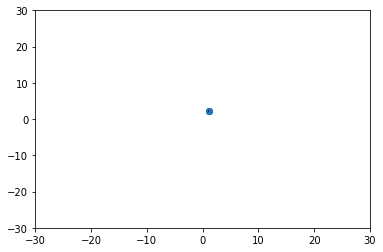

0 0 0
[1.08827060501981, 2.147893555895866]


In [2]:
#make a 2D histogram of the intersections
x = [intersection[0] for intersection in intersections]
y = [intersection[1] for intersection in intersections]
plt.scatter(x,y)
plt.hist2d(x, y, bins=(1000, 1000))
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.show()

xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
rang = [[xmin, xmax], [ymin, ymax]]
H, xedges, yedges = np.histogram2d(x, y,range=rang,bins=len(x)*2)
idx = list(H.flatten()).index(H.max())
x, y = int(idx / H.shape[1]), idx % H.shape[1]
print(idx,x,y)
seed = [(xedges[x]+xedges[x+1])/2.,(yedges[y]+yedges[y+1])/2.]
print(seed)


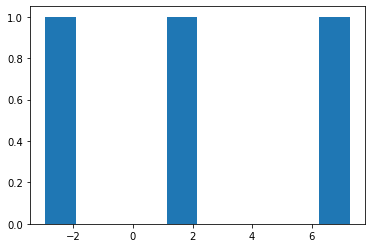

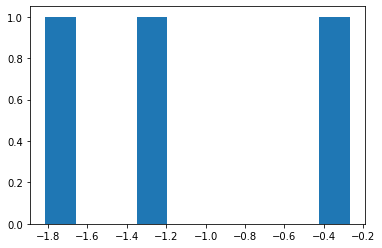

In [3]:
#Transform the rays coordinates to the seed location and check the d0s
reco_d0s   = []
reco_phi0s = []

#print(seed)
seed=[0,10]
  
for r in rays:
    r.transformToPoint(seed)
    reco_d0s.append(r.d0)
    reco_phi0s.append(r.angle)

plt.hist(reco_d0s)
plt.show()

plt.hist(reco_phi0s)
plt.show()


In [4]:
class BilloirSimple2DFitter():
    def __init__(self, tracks):
        self.tracks = tracks
        self.ntracks = len(tracks)
        self.chi2 = 0
        self.x = 0.
        self.y = 0.
        self.track_weights = []                
        
    # from NIM A311 (1992) 139-150
    # For the simple vertex, the D matrix
    # in the plane is a 1x2 matrix.
    def computeD(self,track):
        #deps / dxv
        dd0dxv = +math.sin(track.angle)
        #deps / dxv
        dd0dyv = -math.cos(track.angle)
        dd0_row = np.array([dd0dxv,dd0dyv])
        return dd0_row
    def computewi(self,track):
        Dtrk = self.computeD(track)
        #In this case Wi is the inverse of d0err2
        Wi = 1./ (track.d0err*track.d0err)
        wi = np.outer(Dtrk,Wi*Dtrk)
        return wi
    def computeTrkPerigeePos(self,track):
        xp = +track.d0 * math.sin(track.angle)
        yp = -track.d0 * math.cos(track.angle)
        return np.array([xp,yp])
    
    #This returns an tuple made of (vtxLocation, vtxErrorMatrix)
    def computeVtxLocation(self):
        Swi  = np.array([[0.0,0.0],[0.0,0.0]])
        T    = np.array([0.0,0.0])
        for itrk in range(self.ntracks):
            trk=self.tracks[itrk]
            wtrk = self.computewi(trk)
            Swi += wtrk
            xptrk = self.computeTrkPerigeePos(trk)
            T += wtrk @ xptrk
        
        A=la.inv(Swi)
        V = A @ T
        return (V,A)



lastVtx = [0,10]
errMatrix = None
for i in range(3):
    #print("lastVtx:",lastVtx)
    for iray in range(len(rays)):
        rays[iray].transformToPoint(lastVtx)
        #rays[iray].printTrack()
    
    #billVtx_iter = BilloirSimple2DFitter(raystofit,iter_d0)
    billVtx_iter = BilloirSimple2DFitter(rays)
    dVtx = billVtx_iter.computeVtxLocation()
    print("FitVtx:",dVtx[0])
    print("FitVtxErrorMatrix")
    print(dVtx[1])
    lastVtx += dVtx[0]
    errMatrix = dVtx[1]
    raystofit=[]

print("===>",lastVtx)
    

FitVtx: [ 1.10856201 -7.83791806]
FitVtxErrorMatrix
[[ 1.79141358 -0.77092409]
 [-0.77092409  3.59722654]]
FitVtx: [-0.00143487 -0.0039258 ]
FitVtxErrorMatrix
[[ 3.62416541 -1.27720124]
 [-1.27720124  5.19149936]]
FitVtx: [-0.00143487 -0.0039258 ]
FitVtxErrorMatrix
[[ 3.62416541 -1.27720124]
 [-1.27720124  5.19149936]]
===> [1.10569226 2.15423034]


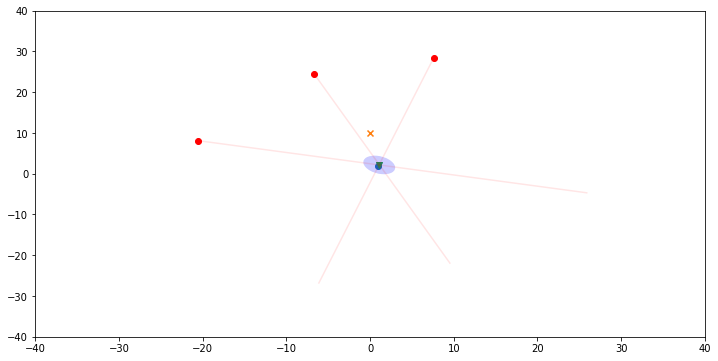

In [5]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

#Plot the vertex + ellipse.
#Method from : https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

#This takes the tuple: vertex location and covariance matrix

def plotEllipse(vtxTuple,ax,n_std=1,facecolor='blue',**kwargs):
    loc = vtxTuple[0]
    cov = vtxTuple[1]
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    #For us, 1 standard deviation is OK, but you can scale it if you prefer.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    
    transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(loc[0], loc[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(12, 6))

for r in rays:
    ax.plot(r.plotOrigin,r.plotEnd,color="red",alpha=0.1)
    ax.scatter(r.origin[0],r.origin[1],color="red")

plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.scatter(0,10,marker="x")
plt.scatter(lastVtx[0],lastVtx[1],marker="v")
plotEllipse((lastVtx,errMatrix),ax,alpha=0.2)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.show()
    
    



0.0
0.0
0.0
0.0
-2.356194490192345 -2.3387411976724017
0.017453292519943295
[-2.356194490192345, 0.017453292519943295]
-2.356194490192345 0.017453292519943295
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


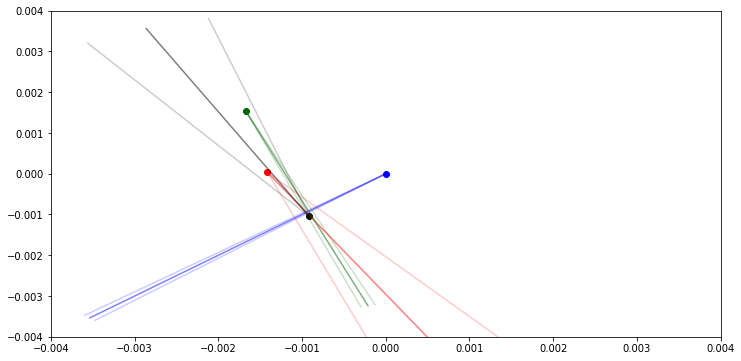

0.00246826829897687
0.007388621210890138
0.008452851513614535
0.0011245049245916378
2.277801222479585e-05
0.0001690136015420789
1.7969706729018857e-05
4.498670598947941e-05
===> [-0.00095016 -0.00095163]
(lon,lat) [-122.24245594311068, 37.24403561134534]


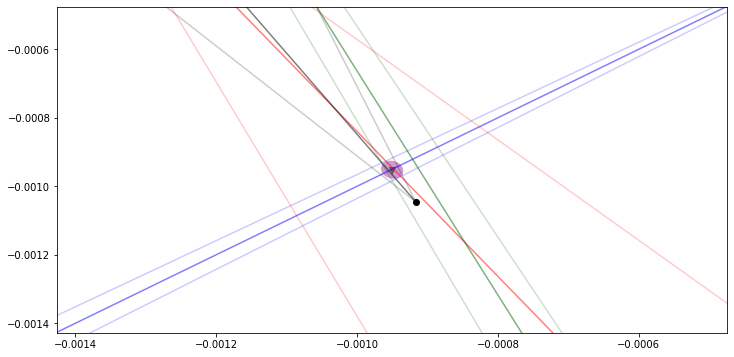

In [6]:
#This snippet should find the vertex for the test data
#lat, lon, angle, error
#37.29856, -122.17402, 225, 1.0
#37.30053, -122.27581, 154.7, 9.0
#37.23866, -122.24004, 337.1, 9.0
#37.38690, -122,29460, 163, 1.0
#The angle should be wrt the true north

#Return the angle between [0,2pi]
def degToRad(angle):
    rad_angle = (angle / 180.)*(math.pi)
    return rad_angle

def radToDeg(rad_angle):
    angle = (rad_angle / math.pi)*180.
    return angle

#flat earth approx from http://www.edwilliams.org/avform147.htm#flat
#Assumed spherical earth
#Angles in deg
def toFlat(lon0,lat0,lon,lat,R=6378.137):
    dlat=degToRad(lat)-degToRad(lat0) 
    dlon=degToRad(lon)-degToRad(lon0)
    distance_North=R*dlat
    distance_East=R*math.cos(degToRad(lat0))*dlon
    return [distance_East,distance_North]

def toSphere(lon0,lat0,distance_East,distance_North,R=6378.137):
    dlat = distance_North / R
    dlon = distance_East / (R*math.cos(degToRad(lat0)))
    lat = dlat+degToRad(lat0)
    lon = dlon+degToRad(lon0)
    return [radToDeg(lon),radToDeg(lat)]
    
def transAngle(angle):
    rad_angle = degToRad(angle)
    rad_angle = math.pi/2. - rad_angle
    return rad_angle

test_origins_lonlat = [
                    [-122.17402,37.29856],
                    [-122.27581,37.30053],
                    [-122.24004,37.23866],
                    [-122.29460,37.38690]
                    ]

test_origins = [toFlat(-122.17402,37.29856,-122.17402,37.29856,1),
                toFlat(-122.17402,37.29856,-122.27581,37.30053,1),
                toFlat(-122.17402,37.29856,-122.24004,37.23866,1),
                toFlat(-122.17402,37.29856,-122.29460,37.38690,1),
                
]

#for to in test_origins:
#    print(to)
                    
test_angles  = [[transAngle(225.0),degToRad(1.0)], 
                [transAngle(154.7),degToRad(9.0)], 
                [transAngle(337.1),degToRad(9.0)],
                [transAngle(163.0),degToRad(1.0)]]

test_rays=[]

for i in range(len(test_origins)):
    #print(test_origins[i],test_angles[i][0])
    test_rays.append(ray(test_origins[i],test_angles[i][0],0.005,test_angles[i][1]))
    
fig, ax = plt.subplots(figsize=(12, 6))
colors=["blue","red","black","darkgreen"]
for itray in range(len(test_rays)):
    ax.plot(test_rays[itray].plotOrigin,test_rays[itray].plotEnd,color=colors[itray],alpha=0.5)
    ax.scatter(test_rays[itray].origin[0],test_rays[itray].origin[1],color=colors[itray])

#Error Ray - 1
print(transAngle(225.0),transAngle(224.0))
print(degToRad(1.))
print(test_angles[0])
print(test_angles[0][0],test_angles[0][1])
err_ray_1 = ray(test_origins[0],test_angles[0][0]+test_angles[0][1],0.005,0)
err_ray_2 = ray(test_origins[0],test_angles[0][0]-test_angles[0][1],0.005,0)
err_ray_3 = ray(test_origins[1],test_angles[1][0]+test_angles[1][1],0.005,0)
err_ray_4 = ray(test_origins[1],test_angles[1][0]-test_angles[1][1],0.005,0)
err_ray_5 = ray(test_origins[2],test_angles[2][0]+test_angles[2][1],0.005,0)
err_ray_6 = ray(test_origins[2],test_angles[2][0]-test_angles[2][1],0.005,0)
err_ray_7 = ray(test_origins[3],test_angles[3][0]+test_angles[3][1],0.005,0)
err_ray_8 = ray(test_origins[3],test_angles[3][0]-test_angles[3][1],0.005,0)

ax.plot(err_ray_1.plotOrigin,err_ray_1.plotEnd,color=colors[0],alpha=0.2)
ax.plot(err_ray_2.plotOrigin,err_ray_2.plotEnd,color=colors[0],alpha=0.2)
ax.plot(err_ray_3.plotOrigin,err_ray_3.plotEnd,color=colors[1],alpha=0.2)
ax.plot(err_ray_4.plotOrigin,err_ray_4.plotEnd,color=colors[1],alpha=0.2)
ax.plot(err_ray_5.plotOrigin,err_ray_5.plotEnd,color=colors[2],alpha=0.2)
ax.plot(err_ray_6.plotOrigin,err_ray_6.plotEnd,color=colors[2],alpha=0.2)
ax.plot(err_ray_7.plotOrigin,err_ray_7.plotEnd,color=colors[3],alpha=0.2)
ax.plot(err_ray_8.plotOrigin,err_ray_8.plotEnd,color=colors[3],alpha=0.2)
plt.xlim(-0.004,0.004)
plt.ylim(-0.004,0.004)

    
plt.show()
fig.savefig("GabeData1.pdf")


lastVtx = [0.1,0.1]
errMatrix = None
iter_d0=[]
raystofit=[]
for i in range(2):
    #print("lastVtx:",lastVtx)
    for iray in range(len(test_rays)):
        test_rays[iray].transformToPoint(lastVtx)
        raystofit.append(test_rays[iray])
        #test_rays[iray].printTrack()
        print(test_rays[iray].d0err)
    
    #billVtx_iter = BilloirSimple2DFitter(raystofit,iter_d0)
    billVtx_iter = BilloirSimple2DFitter(raystofit)
    dVtx = billVtx_iter.computeVtxLocation()
    #print("FitVtx:",dVtx[0])
    #print("FitVtxErrorMatrix")
    #print(dVtx[1])
    lastVtx += dVtx[0]
    errMatrix = dVtx[1]
    raystofit=[]

print("===>",lastVtx)
print("(lon,lat)",toSphere(-122.17402,37.29856,lastVtx[0],lastVtx[1],1))


fig, ax = plt.subplots(figsize=(12, 6))
colors=["blue","red","black","darkgreen"]
for itray in range(len(test_rays)):
    ax.plot(test_rays[itray].plotOrigin,test_rays[itray].plotEnd,color=colors[itray],alpha=0.5)
    ax.scatter(test_rays[itray].origin[0],test_rays[itray].origin[1],color=colors[itray])

    
ax.plot(err_ray_1.plotOrigin,err_ray_1.plotEnd,color=colors[0],alpha=0.2)
ax.plot(err_ray_2.plotOrigin,err_ray_2.plotEnd,color=colors[0],alpha=0.2)
ax.plot(err_ray_3.plotOrigin,err_ray_3.plotEnd,color=colors[1],alpha=0.2)
ax.plot(err_ray_4.plotOrigin,err_ray_4.plotEnd,color=colors[1],alpha=0.2)
ax.plot(err_ray_5.plotOrigin,err_ray_5.plotEnd,color=colors[2],alpha=0.2)
ax.plot(err_ray_6.plotOrigin,err_ray_6.plotEnd,color=colors[2],alpha=0.2)
ax.plot(err_ray_7.plotOrigin,err_ray_7.plotEnd,color=colors[3],alpha=0.2)
ax.plot(err_ray_8.plotOrigin,err_ray_8.plotEnd,color=colors[3],alpha=0.2)
    
plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.scatter(0,10,marker="x")
plt.scatter(lastVtx[0],lastVtx[1],marker="v")
plotEllipse((lastVtx,errMatrix),ax,alpha=0.4,facecolor="darkmagenta")
f=0.5
plt.xlim([lastVtx[0]-abs(f*lastVtx[0]),lastVtx[0]+abs(f*lastVtx[0])])
plt.ylim([lastVtx[1]-abs(f*lastVtx[1]),lastVtx[1]+abs(f*lastVtx[1])])
plt.show()

fig.savefig("GabeDataFit.pdf")


In [7]:
#params:
#csv filename
#delimiter
#skip the header
#choose if the origin is the first location or the mean of the locations
#returs:
#tracks in flat earth approx and origin of the flat earth plane
def csv2rays(csvname,delimiter=',',skipHeader=True, doMeanOrigin=False):
    import csv
    tracks=[]
    #In lon-lat
    locations=[]
    #In angle-error already transformed and in rad
    angles=[]
    #This is custom
    length=0.005
    with open(csvname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=delimiter)
        line_count = 0
        for row in csv_reader:
            line_count+=1
            if line_count==1 and skipHeader:
                continue
            else:
                #print(row)
                locations.append([float(row[2]),float(row[1])])
                angle = float(row[3])
                s_angle = float(row[4])
                angles.append([transAngle(angle),degToRad(s_angle)])
    OriginX=None
    OriginY=None
    if doMeanOrigin:
        tmpX=0.0
        tmpY=0.0
        for l in locations:
            tmpX += l[0]
            tmpY += l[1]
        OriginX=tmpX/float(len(locations))
        OriginY=tmpY/float(len(locations))
    else:
        OriginX=locations[0][0]
        OriginY=locations[0][1]
        
    #Transform lon-lat to flat and form the tracks
    for i in range(len(locations)):
        origin = toFlat(OriginX,OriginY,locations[i][0],locations[i][1],1)
        #print(origin,angles[i])
        tracks.append(ray(origin,angles[i][0],length,angles[i][1]))
    return tracks,[OriginX,OriginY]
            
def plotTracks(tracks,limX=[-0.003,0.003],limY=[-0.003,0.003],doErrors=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    #colors=["blue","red","black","darkgreen","darkorchid"]
    for itray in range(len(tracks)):
        trk=tracks[itray]
        #ax.plot(tracks[itray].plotOrigin,tracks[itray].plotEnd,color=colors[itray],alpha=0.5)
        #ax.scatter(tracks[itray].origin[0],tracks[itray].origin[1],color=colors[itray])
        ax.plot(trk.plotOrigin,trk.plotEnd,color='red',alpha=0.5)
        if doErrors:
            trk_1p=ray(trk.origin,trk.angle+trk.sigma_angle,trk.length,0)
            trk_1m=ray(trk.origin,trk.angle-trk.sigma_angle,trk.length,0)
            ax.plot(trk_1p.plotOrigin,trk_1p.plotEnd,color="red",alpha=0.1)
            ax.plot(trk_1m.plotOrigin,trk_1m.plotEnd,color="red",alpha=0.1)
        ax.scatter(tracks[itray].origin[0],tracks[itray].origin[1],color='red')
    plt.xlim(limX[0],limX[1])
    plt.ylim(limY[0],limY[1])
 
    return fig,ax
    
def vtxTracks(tracks,ref=[0.,0.],iterations=2):
    lastVtx = ref
    errMatrix = None
    raystofit=[]
    for i in range(iterations):
        for iray in range(len(tracks)):
            tracks[iray].transformToPoint(lastVtx)
            raystofit.append(tracks[iray])
    
        billVtx_iter = BilloirSimple2DFitter(raystofit)
        dVtx = billVtx_iter.computeVtxLocation()
        lastVtx += dVtx[0]
        errMatrix = dVtx[1]
        raystofit.clear()
    return lastVtx,errMatrix

    


0.0
0.0
0.0
0.0
0.0
truth_vtx 0.0008570150568970595 0.00033934436646532173
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[0.00086869 0.00035706]
(lon,lat) [-122.10646081809328, 37.15351486599652]
(lon_truth,lat_truth) -122.1073 37.1525


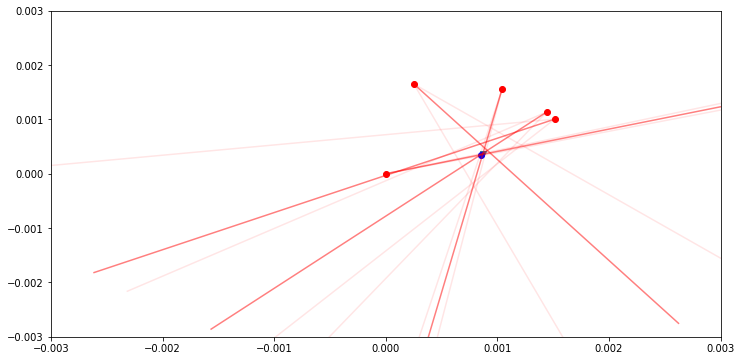

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


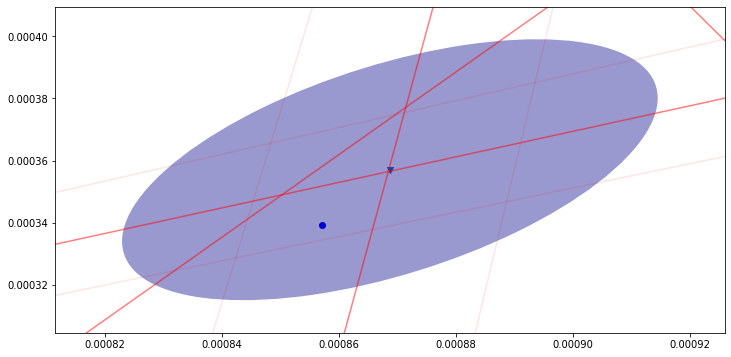

In [8]:
truth_vtx_1=[-122.1073,37.1525]
tracks,O = csv2rays("6570eb52-3795-45ae-a951-534ce918b8e2",doMeanOrigin=False)

truth_vtx_1_flat = toFlat(O[0],O[1],truth_vtx_1[0],truth_vtx_1[1],1)
print("truth_vtx",truth_vtx_1_flat[0],truth_vtx_1_flat[1])
fig,ax = plotTracks(tracks)
vtx,cov = vtxTracks(tracks,O)
vtx_Cam_1,cov_Cam_1 = vtx,cov
print(vtx)
vtx_Cam_1_sphere = toSphere(O[0],O[1],vtx[0],vtx[1],1)
print("(lon,lat)",toSphere(O[0],O[1],vtx[0],vtx[1],1))
print("(lon_truth,lat_truth)",truth_vtx_1[0],truth_vtx_1[1])

ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_1_flat[0],truth_vtx_1_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
plt.show()


f=2.5
fig,ax = plotTracks(tracks)
ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_1_flat[0],truth_vtx_1_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue",n_std=2)
vsigmax=math.sqrt(cov[0,0])
vsigmay=math.sqrt(cov[1,1])
plt.xlim(vtx[0]-f*vsigmax,vtx[0]+f*vsigmax)
plt.ylim(vtx[1]-f*vsigmay,vtx[1]+f*vsigmay)
plt.show()



0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[-5.66648765e-05 -3.80694823e-04]
(lon,lat) [-122.29771725554963, 37.44550619415402]
(lon_truth,lat_truth) -122.30148 37.44424


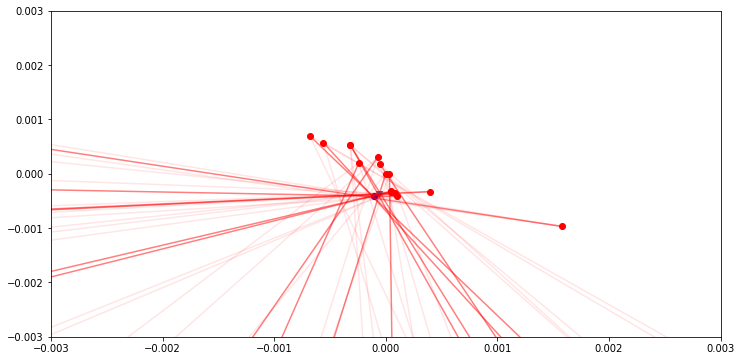

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


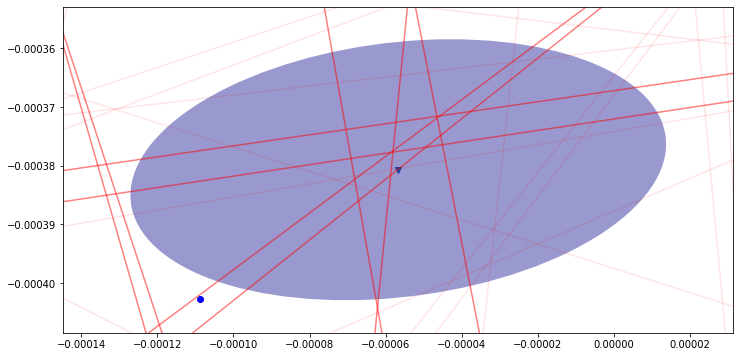

In [9]:
truth_vtx_2=[-122.30148,37.44424]
tracks,O = csv2rays("e3203b9b-9162-451e-854f-cd95c76b9654",doMeanOrigin=False)

truth_vtx_2_flat = toFlat(O[0],O[1],truth_vtx_2[0],truth_vtx_2[1],1)

fig,ax = plotTracks(tracks)
vtx,cov = vtxTracks(tracks,O)
vtx_Cam_2,cov_Cam_2 = vtx,cov
print(vtx)
vtx_Cam_2_sphere = toSphere(O[0],O[1],vtx[0],vtx[1],1)
print("(lon,lat)",toSphere(O[0],O[1],vtx[0],vtx[1],1))
print("(lon_truth,lat_truth)",truth_vtx_2[0],truth_vtx_2[1])

ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_2_flat[0],truth_vtx_2_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
plt.show()


f=2.5
fig,ax = plotTracks(tracks)
ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_2_flat[0],truth_vtx_2_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue",n_std=2)
vsigmax=math.sqrt(cov[0,0])
vsigmay=math.sqrt(cov[1,1])
plt.xlim(vtx[0]-f*vsigmax,vtx[0]+f*vsigmax)
plt.ylim(vtx[1]-f*vsigmay,vtx[1]+f*vsigmay)
plt.show()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[-0.00053007 -0.00065584]
(lon,lat) [-122.1033478393353, 37.16055257889672]
(lon_truth,lat_truth) -122.1073 37.1525
truth_vtx -0.0005850161791013011 -0.0007963861675429618


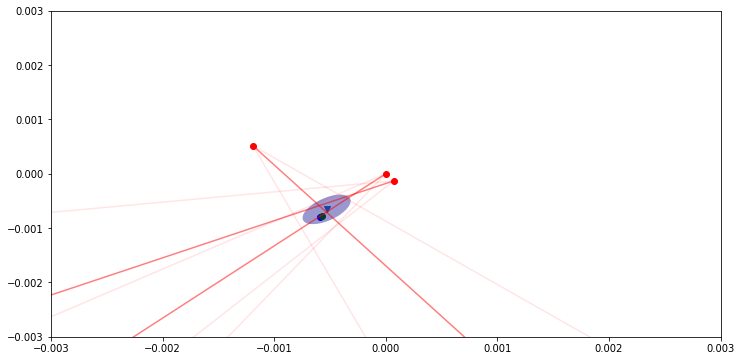

0.0
0.0
0.0
0.0
0.0
0.0


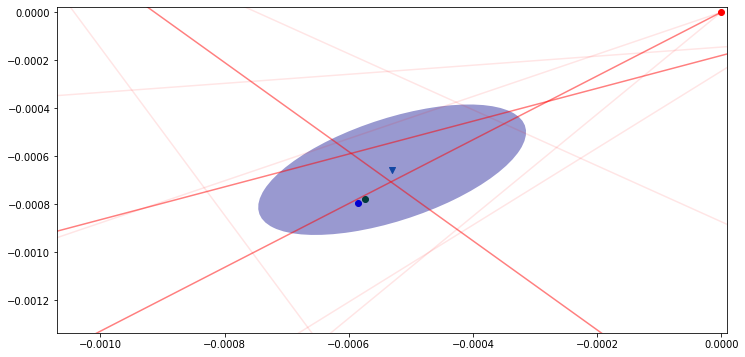

In [10]:
tracks,O = csv2rays("6570eb52-3795-45ae-a951-534ce918b8e2_noCam",doMeanOrigin=False)
truth_vtx_1_flat = toFlat(O[0],O[1],truth_vtx_1[0],truth_vtx_1[1],1)
vtx_Cam_1_flat = toFlat(O[0],O[1],vtx_Cam_1_sphere[0],vtx_Cam_1_sphere[1],1)
fig,ax = plotTracks(tracks)
vtx,cov = vtxTracks(tracks,O)
print(vtx)
print("(lon,lat)",toSphere(O[0],O[1],vtx[0],vtx[1],1))
print("(lon_truth,lat_truth)",truth_vtx_1[0],truth_vtx_1[1])
print("truth_vtx",truth_vtx_1_flat[0],truth_vtx_1_flat[1])

ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_1_flat[0],truth_vtx_1_flat[1],marker="o",color="blue")
ax.scatter(vtx_Cam_1_flat[0],vtx_Cam_1_flat[1],marker="o",color="darkgreen")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
plt.show()

f=2.5
fig,ax = plotTracks(tracks)
ax.scatter(vtx[0],vtx[1],marker="v")

ax.scatter(truth_vtx_1_flat[0],truth_vtx_1_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
ax.scatter(vtx_Cam_1_flat[0],vtx_Cam_1_flat[1],marker="o",color="darkgreen")
vsigmax=math.sqrt(cov[0,0])
vsigmay=math.sqrt(cov[1,1])
plt.xlim(vtx[0]-f*vsigmax,vtx[0]+f*vsigmax)
plt.ylim(vtx[1]-f*vsigmay,vtx[1]+f*vsigmay)
plt.show()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[ 0.0001806  -0.00044104]
[[4.83959268e-12 1.69429786e-12]
 [1.69429786e-12 1.22830812e-10]]
(lon,lat) [-122.2912921054644, 37.44893364837989]
(lon_truth,lat_truth) -122.30148 37.44424
truth_vtx 3.9483599052027115e-05 -0.0005229589807186352


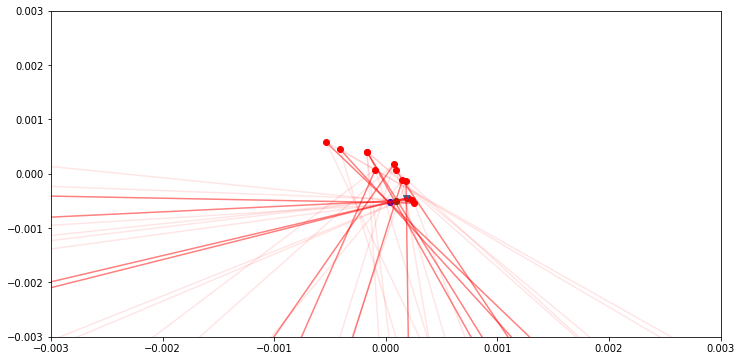

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


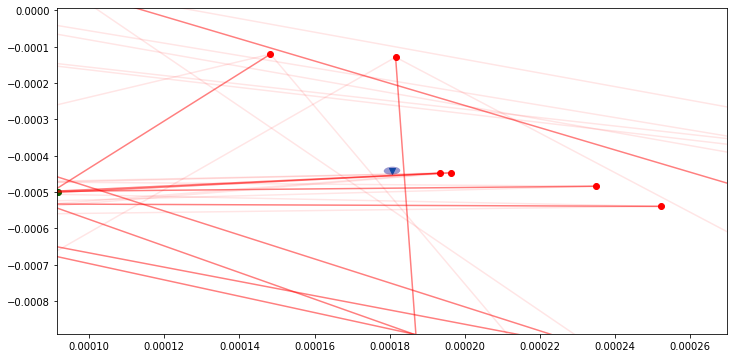

In [11]:
tracks,O = csv2rays("e3203b9b-9162-451e-854f-cd95c76b9654_noCam",doMeanOrigin=True)
truth_vtx_2_flat = toFlat(O[0],O[1],truth_vtx_2[0],truth_vtx_2[1],1)
vtx_Cam_2_flat = toFlat(O[0],O[1],vtx_Cam_2_sphere[0],vtx_Cam_2_sphere[1],1)
fig,ax = plotTracks(tracks)
vtx,cov = vtxTracks(tracks,O)
print(vtx)
print(cov)
print("(lon,lat)",toSphere(O[0],O[1],vtx[0],vtx[1],1))
print("(lon_truth,lat_truth)",truth_vtx_2[0],truth_vtx_2[1])
print("truth_vtx",truth_vtx_2_flat[0],truth_vtx_2_flat[1])

ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_2_flat[0],truth_vtx_2_flat[1],marker="o",color="blue")
ax.scatter(vtx_Cam_2_flat[0],vtx_Cam_2_flat[1],marker="o",color="darkgreen")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
plt.show()

f=40.5
fig,ax = plotTracks(tracks)
ax.scatter(vtx[0],vtx[1],marker="v")

ax.scatter(truth_vtx_2_flat[0],truth_vtx_2_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
ax.scatter(vtx_Cam_2_flat[0],vtx_Cam_2_flat[1],marker="o",color="darkgreen")
vsigmax=math.sqrt(cov[0,0])
vsigmay=math.sqrt(cov[1,1])
plt.xlim(vtx[0]-f*vsigmax,vtx[0]+f*vsigmax)
plt.ylim(vtx[1]-f*vsigmay,vtx[1]+f*vsigmay)
plt.show()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[ 9.16750418e-05 -4.56378425e-04]
[[1.38422853e-09 1.39015289e-10]
 [1.39015289e-10 1.42684291e-10]]
(lon,lat) [-122.29491703229286, 37.4462116174955]
(lon_truth,lat_truth) -122.30148 37.44424
truth_vtx 7.664418771445619e-07 -0.000490789642352385


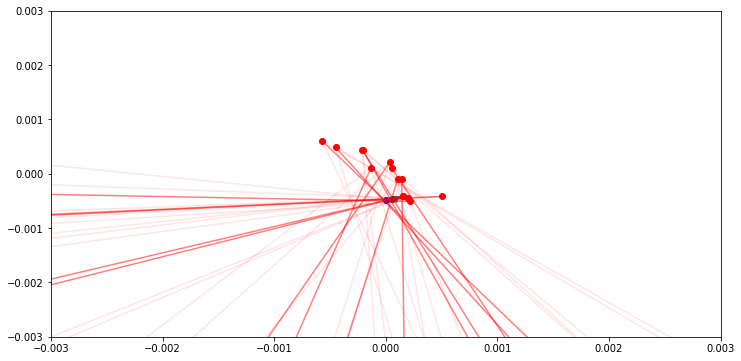

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


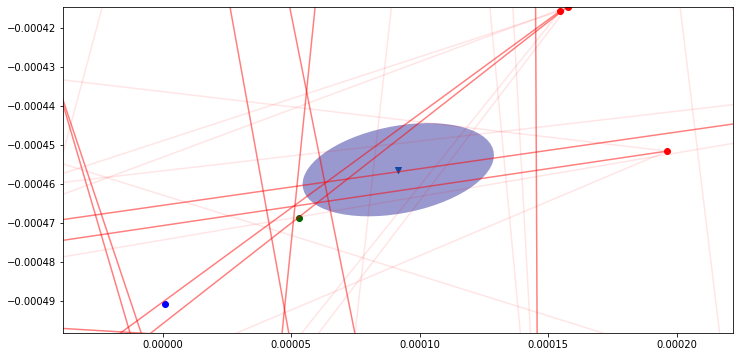

In [12]:
tracks,O = csv2rays("e3203b9b-9162-451e-854f-cd95c76b9654_noFarCam",doMeanOrigin=True)
truth_vtx_2_flat = toFlat(O[0],O[1],truth_vtx_2[0],truth_vtx_2[1],1)
vtx_Cam_2_flat = toFlat(O[0],O[1],vtx_Cam_2_sphere[0],vtx_Cam_2_sphere[1],1)
fig,ax = plotTracks(tracks)
vtx,cov = vtxTracks(tracks,O)
print(vtx)
print(cov)
print("(lon,lat)",toSphere(O[0],O[1],vtx[0],vtx[1],1))
print("(lon_truth,lat_truth)",truth_vtx_2[0],truth_vtx_2[1])
print("truth_vtx",truth_vtx_2_flat[0],truth_vtx_2_flat[1])

ax.scatter(vtx[0],vtx[1],marker="v")
ax.scatter(truth_vtx_2_flat[0],truth_vtx_2_flat[1],marker="o",color="blue")
ax.scatter(vtx_Cam_2_flat[0],vtx_Cam_2_flat[1],marker="o",color="darkgreen")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
plt.show()

f=3.5
fig,ax = plotTracks(tracks)
ax.scatter(vtx[0],vtx[1],marker="v")

ax.scatter(truth_vtx_2_flat[0],truth_vtx_2_flat[1],marker="o",color="blue")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
ax.scatter(vtx_Cam_2_flat[0],vtx_Cam_2_flat[1],marker="o",color="darkgreen")
vsigmax=math.sqrt(cov[0,0])
vsigmay=math.sqrt(cov[1,1])
plt.xlim(vtx[0]-f*vsigmax,vtx[0]+f*vsigmax)
plt.ylim(vtx[1]-f*vsigmay,vtx[1]+f*vsigmay)
plt.show()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[-3.03180511e-05 -1.75443987e-03]
[[6.43083991e-10 1.76304033e-10]
 [1.76304033e-10 7.52252848e-10]]
(lon,lat) [-122.2281746651636, 37.223189250264525]


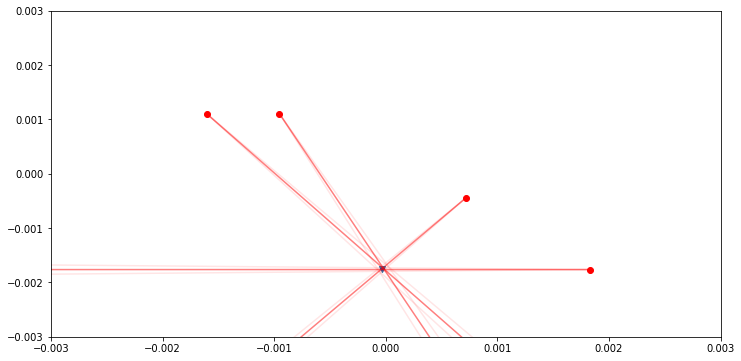

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


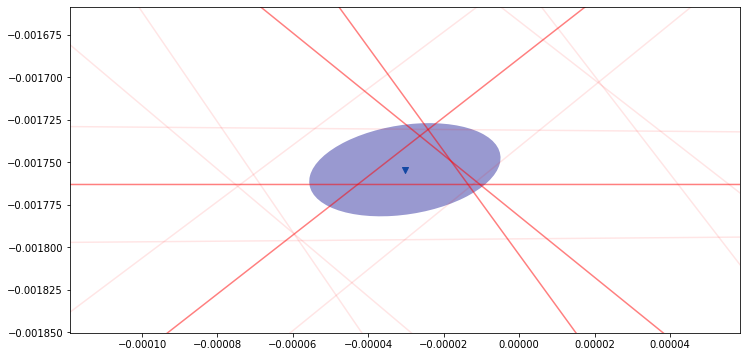

In [14]:
tracks,O = csv2rays("faultyFit",doMeanOrigin=True)
fig,ax = plotTracks(tracks)
vtx,cov = vtxTracks(tracks,O)
print(vtx)
print(cov)
print("(lon,lat)",toSphere(O[0],O[1],vtx[0],vtx[1],1))

ax.scatter(vtx[0],vtx[1],marker="v")
plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
plt.show()

f=3.5
fig,ax = plotTracks(tracks)
ax.scatter(vtx[0],vtx[1],marker="v")

plotEllipse((vtx,cov),ax,alpha=0.4,facecolor="darkblue")
vsigmax=math.sqrt(cov[0,0])
vsigmay=math.sqrt(cov[1,1])
plt.xlim(vtx[0]-f*vsigmax,vtx[0]+f*vsigmax)
plt.ylim(vtx[1]-f*vsigmay,vtx[1]+f*vsigmay)
plt.show()